# Brain Tumor Segmentation using UNet

## Imports

In [19]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

plt.style.use("dark_background")

## Read & Prepare Data

In [2]:
DATA_PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

Within path '/kaggle/input/lgg-mri-segmentation/kaggle_3m/' there are folders of structure:
`TCGA_CS_patientId_sliceNumber/TCGA_CS_patientId_sliceNumber_num.tif` **---> for image**
`TCGA_CS_patientId_sliceNumber/TCGA_CS_patientId_sliceNumber_num_mask.tif` **---> for mask**

To get all images and mask we will use glob. Glob is used for pattern matching and directory searching.

Eg: `file1.txt`, `file2.txt`, `file3.csv`, `data.txt`, `data.csv`

`txt_files = glob.glob("*.txt")` will get you all .txt files i.e. `file1.txt` `file2.txt` `data.txt`

We will store image path and mask path in a dataframe

In [3]:
df = pd.DataFrame()
df["mask_file"] = glob.glob(DATA_PATH+"*/*_mask.tif")
df["img_file"] = [path.replace("_mask","") for path in df["mask_file"]]

In [4]:
df["patient_id"] = [path.split("/")[-2] for path in df["mask_file"]]

In [5]:
def get_label(path):
    """Check if there is any mask on mask image or not to get label(tumor or not)"""
    mask = Image.open(path)
    mask = np.asarray(mask)

    return int(mask.max() > 0) # if there is no mask, it will be all black i.e. 0 else if any pixel is white=1, returns True/1

In [6]:
df["tumor_diagnosis"] = df["mask_file"].apply(get_label)

In [7]:
df

,mask_file,img_file,patient_id,tumor_diagnosis
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307,1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307,1
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307,1
...,...,...,...,...
3924,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7306_19930512,0
3925,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7306_19930512,0
3926,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7306_19930512,0
3927,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7306_19930512,0


In [8]:
df.iloc[0,0],df.iloc[0,1], df.iloc[0,2], df.iloc[0,3] 

('/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif',
 '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif',
 'TCGA_DU_7010_19860307',
 0)

In [9]:
df = df[['patient_id', 'img_file', 'mask_file', 'tumor_diagnosis']]
df

,patient_id,img_file,mask_file,tumor_diagnosis
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


## Data Visualization and Analysis

In [15]:
def plot_samples(value:bool):
    """Function to visualize samples of MRI images and corresponding masks"""
    sample_df = df[df['tumor_diagnosis']==int(value)]
    idx = np.random.randint(0, len(sample_df), (5))
    plt.figure(figsize=(15, 15))

    for i in range(5):
        row = sample_df.iloc[idx[i]]
        plt.subplot(5, 2, i*2+1)
        img = Image.open(row["img_file"])
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(5, 2, i*2+2)
        mask = Image.open(row["mask_file"])
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


**MRI with Tumor**

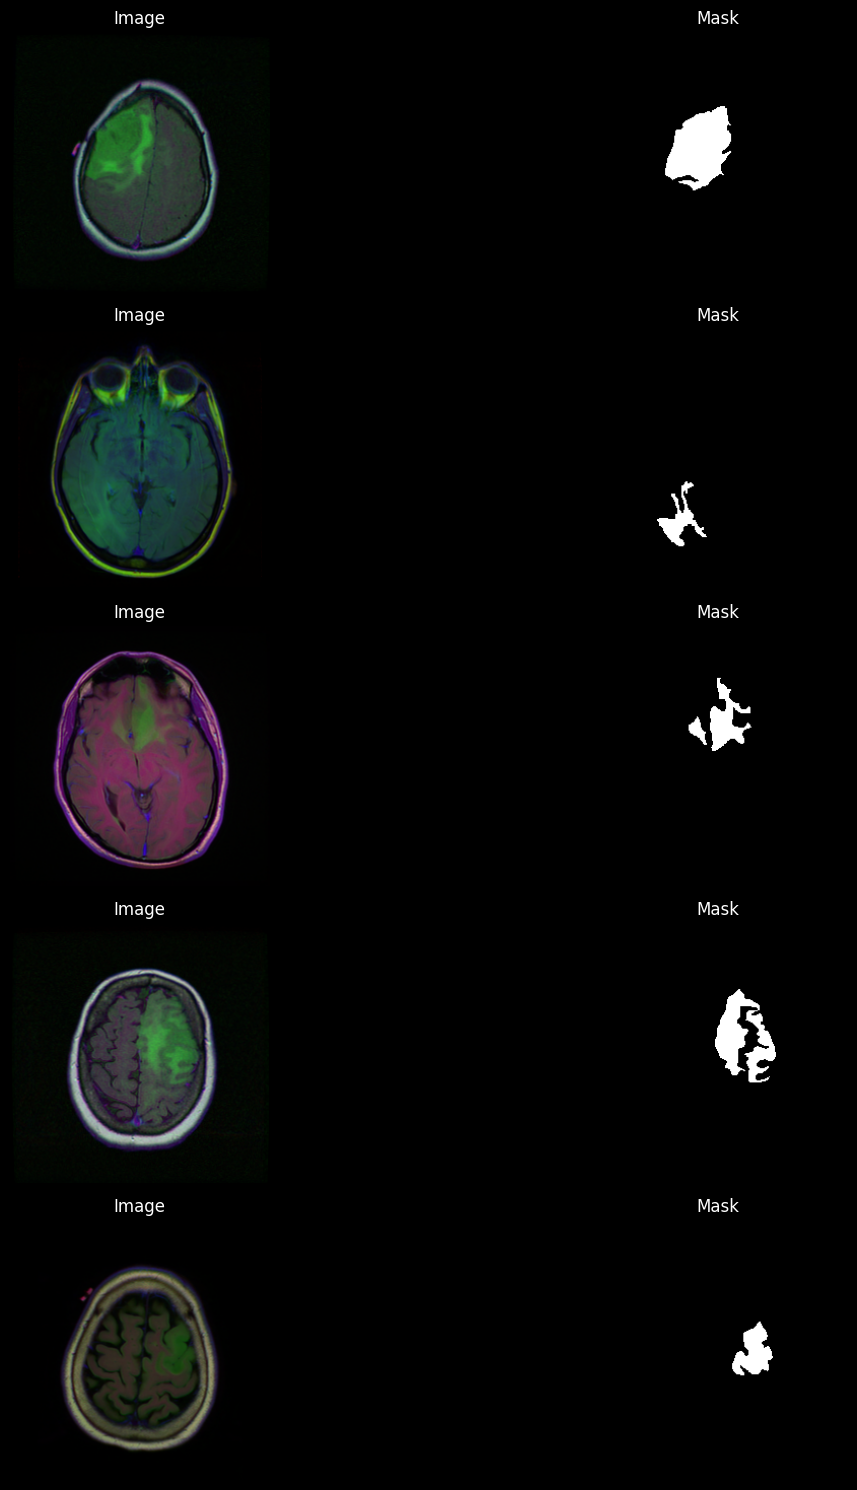

In [16]:
# MRI With tumor
plot_samples(True)

**MRI without Tumor**

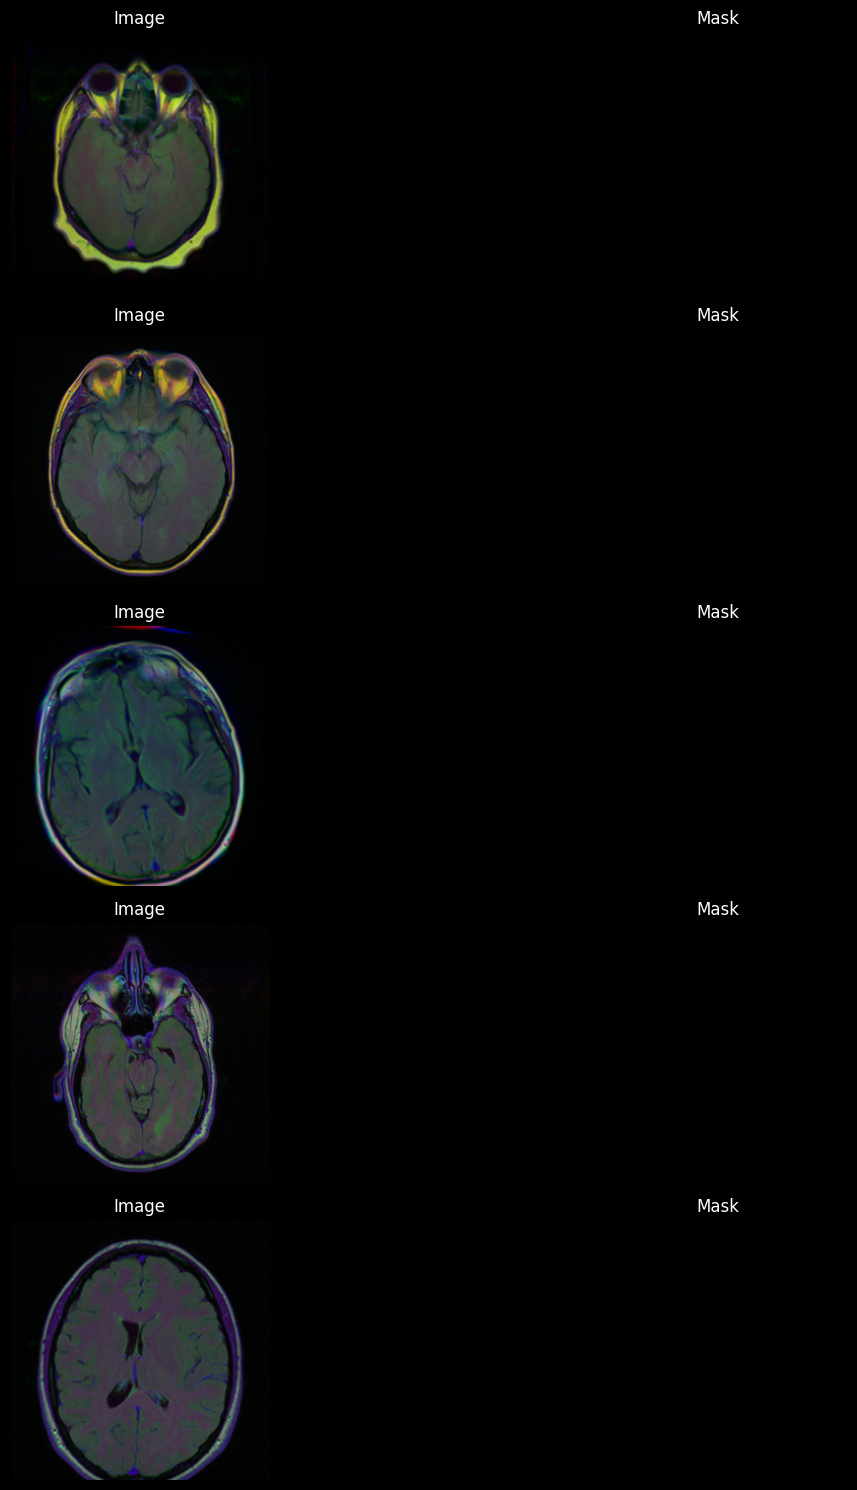

In [17]:
# MRI without Tumor
plot_samples(False)

In [11]:
df['patient_id'].nunique()

110

There are a total of 110 patients.

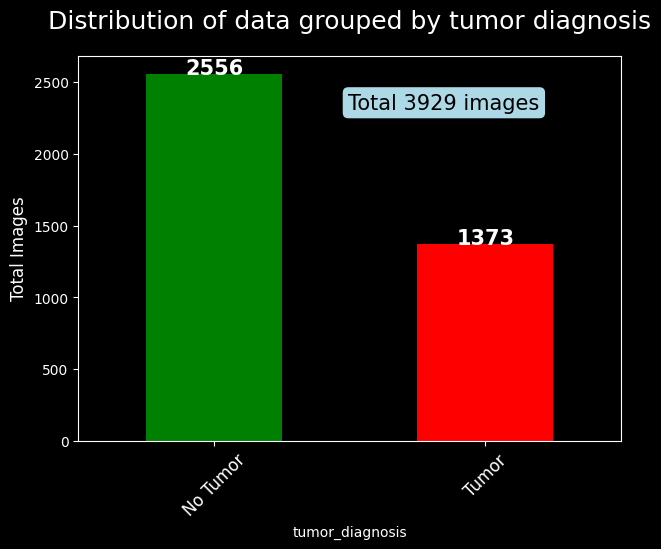

In [12]:
# Data for the bar graph
diagnosis_counts = df['tumor_diagnosis'].value_counts()

# Plot
fig = diagnosis_counts.plot(kind='bar', stacked=True, figsize=(7, 5), color=["green", "red"])

# Customizing the plot
fig.set_xticklabels(["No Tumor", "Tumor"], rotation=45, fontsize=12)
fig.set_ylabel('Total Images', fontsize=12)
fig.set_title("Distribution of data grouped by tumor diagnosis", fontsize=18, y=1.05)

# Annotate each bar with its value
for i, count in enumerate(diagnosis_counts.values):
    fig.annotate(int(count), xy=(i, count - 30), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")

# Add text for total number of images
fig.text(1.2, max(diagnosis_counts) - 200, f"Total {len(df)} images", size=15,
        color="black",
        ha="right", va="center",
        bbox=dict(boxstyle="round",
                  fc=("lightblue"),
                  ec=("black"),
                  )
        )

plt.show()


Total data of 110 patients is 3929. Out of which, 1373 images has detected tumor in it while remaining 2556 images show no tumor in it.

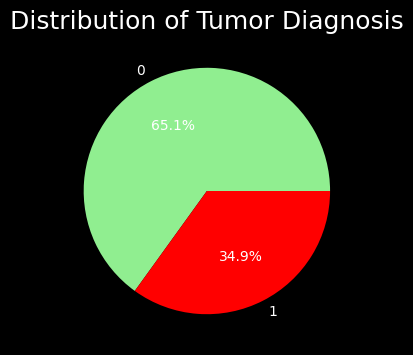

In [13]:
# Plot
plt.figure(figsize=(5, 4))
plt.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', colors=["lightgreen", "red"])

# Title
plt.title("Distribution of Tumor Diagnosis", fontsize=18)

# Display the plot
plt.show()

Looks like 34.9% of data has tumor detected on it while 65.1% of data doesn't show tumor.

Let's see distribution for each patient to see their tumor presence. 

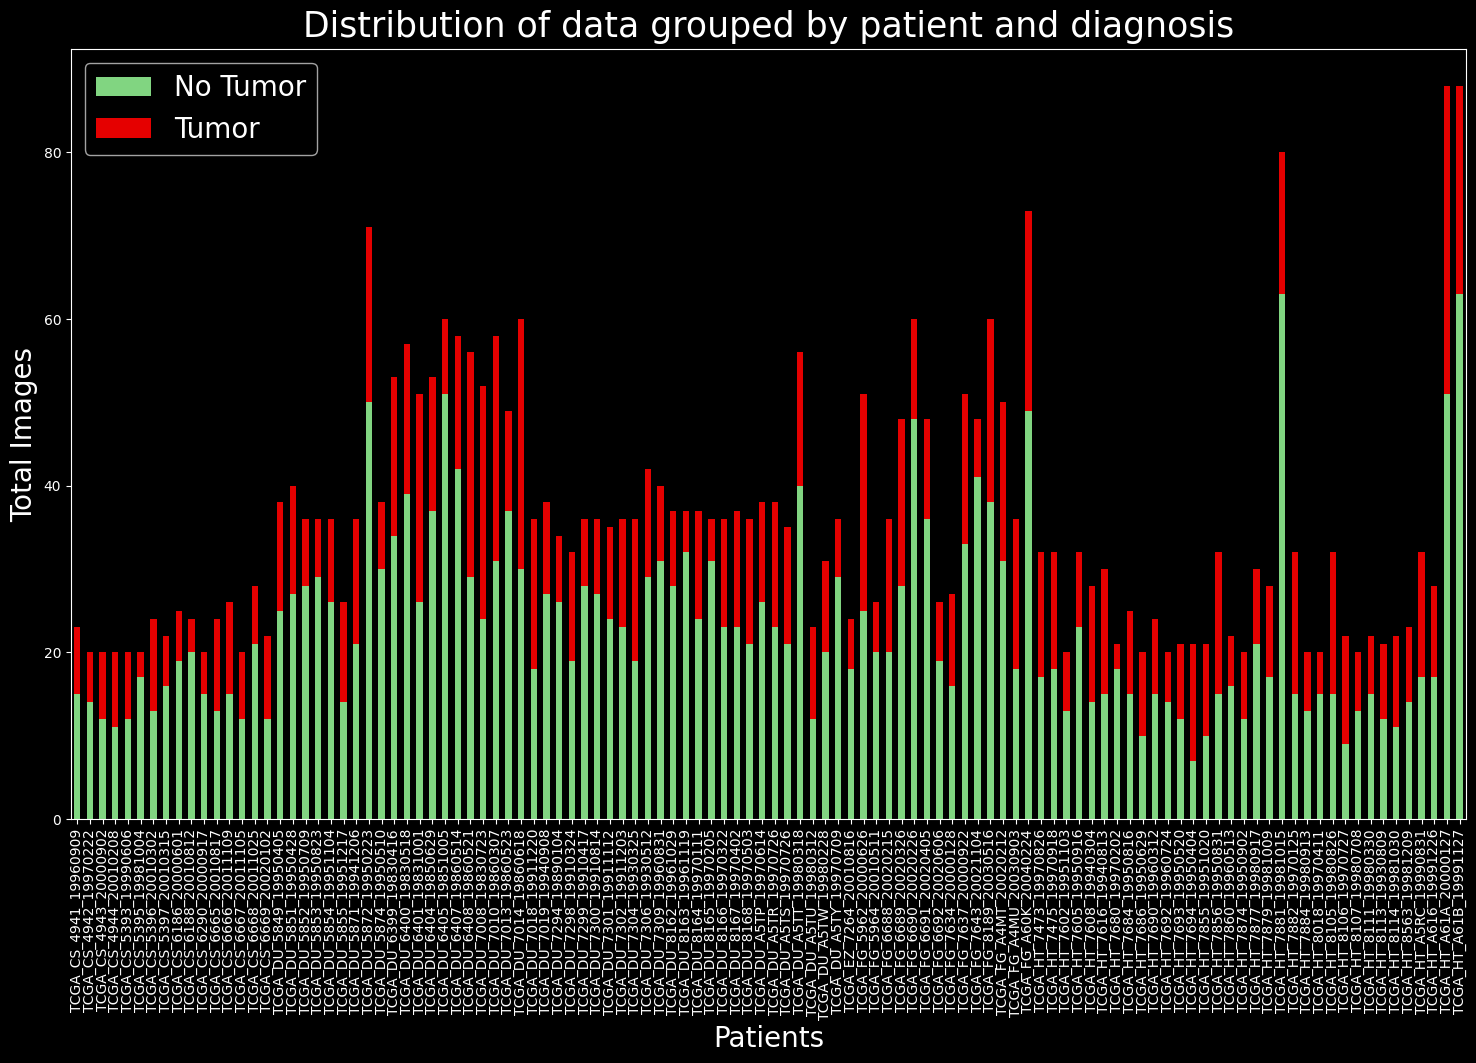

In [14]:
patients_by_diagnosis = df.groupby(['patient_id', 'tumor_diagnosis'])['tumor_diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["No Tumor", "Tumor"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["lightgreen", "red"],
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

plt.show()

From above distribution graph we can see not all patient have same amount of MRI. The minimum number of MRI per patient looks to be 20. Some patients even have as much as 80+ MRIs. Also we can see that each patient has tumor in atleast one of their MRI. We can also conclude that it is difficult to detect tumor in MRI as we can see most MRI doesn't detect tumor while only some can. In medical insight, we can say that it is best to take as much MRI as needed for tumor detection and localization. 

## Transformations

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Dataset and DataLoader

In [73]:
class MRIDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = Image.open(self.df['img_file'][idx])
        mask = Image.open(self.df['mask_file'][idx])

        if self.transforms:
            image,mask = self.transforms((image,mask))
#             mask = self.transforms(mask)  
# As we are using random transformations, using them separately will cause mask to get randomly transformed 
# irrespective to how MRI is transformed
        
        return (image, mask)

In [22]:
# transforms = transforms.Compose([
#     transforms.RandomAffine(degrees=15,translate=(0.1,0.1), scale=(0.9, 1.1), shear=10),
#     transforms.RandomHorizontalFlip(p=0.2),
#     transforms.RandomGrayscale(p=0.1),
# #     transforms.ToPILImage(),
# #     transforms.AutoAugment()
# #     transforms.RandomEqualize(p=0.2),
#     transforms.ToTensor(),
# #     #transforms.Normalize(normalize img across 3 channels and mask along single channel)
# ])

In [76]:
class RandomGrayScale():
    """Performs random horizontal flip with given probaility"""
    def __init__(self,p=0.5):
        self.prob = p

    def __call__(self, pair):
        img,mask = pair
        if torch.rand((1,)).item() > self.prob:
            img,mask = TF.rgb_to_grayscale(img), TF.to_grayscale(mask)

        return img,mask


class RandomHFlip():
    """Performs random horizontal flip with given probaility"""
    def __init__(self,p=0.5):
        self.prob = p

    def __call__(self, pair):
        img,mask = pair
        if torch.rand((1,)).item() > self.prob:
            img,mask = TF.hflip(img), TF.hflip(mask)

        return img,mask
    
    
class RandomAffine():
    """Performs random affine transformation(rotate, translate, scaling and shear) with given probaility"""
    def __init__(self, degrees=None, translate=None, scale_ranges=None, shears=None):
        self.degrees=degrees
        self.translate=translate
        self.scale_ranges=scale_ranges
        self.shears=shears

    def __call__(self, pair):
        img, mask = pair
        w, h = img.size

        #get parameters for random affine transformations
        angle, translations, scale, shear = transforms.RandomAffine.get_params(degrees = self.degrees,translate = self.translate, scale_ranges=self.scale_ranges, shears = self.shears,img_size=(w,h))
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        return img, mask
    
    
class ToTensorPair():
    """Convert PIL image to tensor, also does normalization"""
    def __call__(self,pair):
        img,mask = pair
        img,mask = transforms.ToTensor()(img), transforms.ToTensor()(mask)

        return img,mask

In [81]:
# Define your individual transforms
random_hflip = RandomHFlip(0.2)
random_affine = RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale_ranges=(1, 1.3), shears=(-7, 7))
# random_grayscale = RandomGrayScale(0.2)
to_tensor_pair = ToTensorPair()

# Compose the transforms into a pipeline
transform = transforms.Compose([
    random_hflip,
    random_affine,
#     random_grayscale,
    to_tensor_pair
])

In [82]:
dataset = MRIDataset(df,transform)

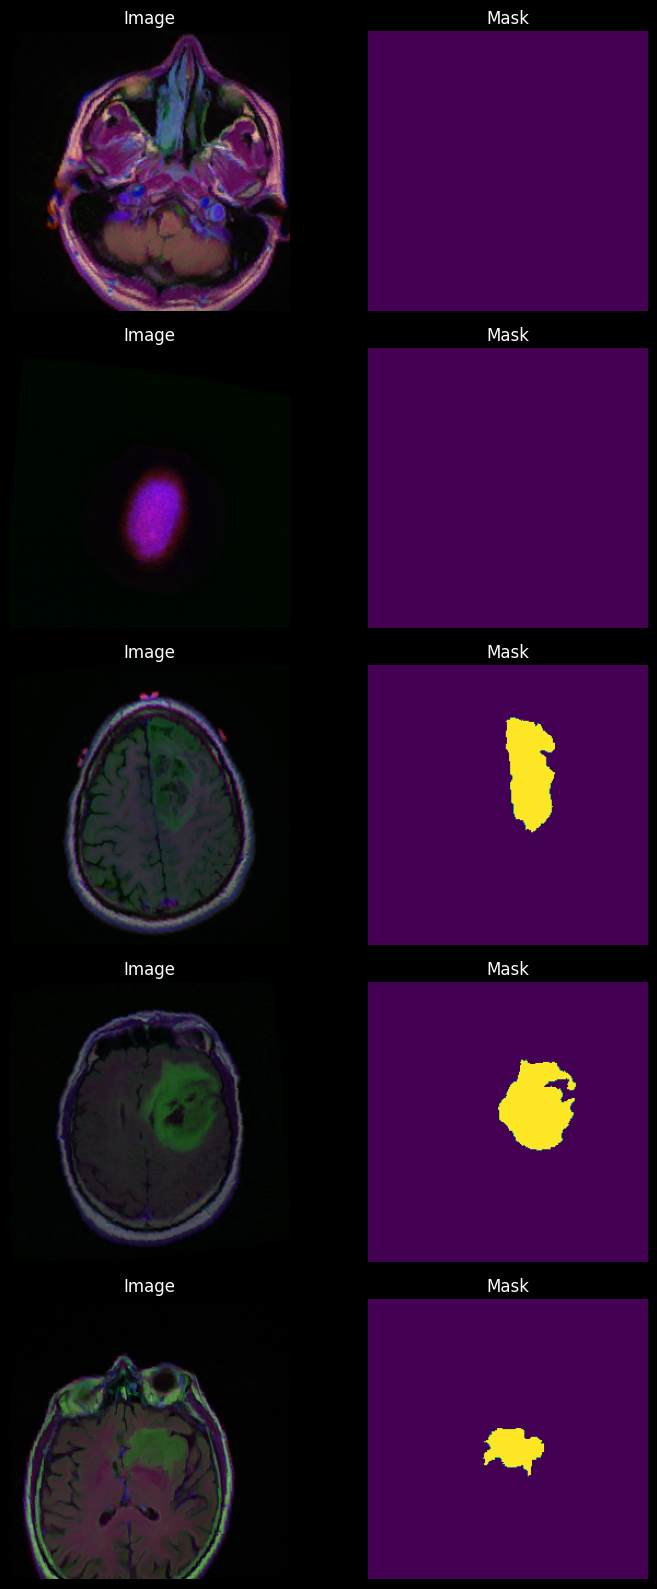

In [83]:
def show_samples():
    idx = np.random.randint(0, len(dataset), (5))
    plt.figure(figsize=(8,16))

    for i in range(5):
        img, mask = dataset[idx[i]]
        plt.subplot(5, 2, i * 2 + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(5, 2, i * 2 + 2)
        plt.imshow(mask.permute(1, 2, 0))# extent=[0, mask.size(2), mask.size(1), 0])
        plt.title("Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_samples()